# ПРОЕКТ: Прогнозирование заказов такси

Я работаю в компании: «Чётенькое такси», которая занимается перевозкой пассажиров.\
В нашем сервисе возникла необходимость привлекать больше водителей в период пиковой нагрузки. \
В моём распоряжении исторические данные о заказах такси в аэропортах.

**Цель проекта**: построить модель, которая умеет прогнозировать количество заказов такси на следующий час.
- Критерий, который важен заказчику:\
*Значение метрики RMSE на тестовой выборке должно быть не больше 48.*

**Ход исследования:**

*Шаг 1* - Загрузка и ресемплирование данных по одному часу;\
*Шаг 2* - Анализ данных;\
*Шаг 3* - Обучение моделей с различными гиперпараметрами;\
*Шаг 4* - Проверка данных на тестовой выборке.

Итоговый вывод.

## Шаг 1. Загрузка и ресемплирование данных по одному часу

In [1]:
!pip install catboost -q
!pip install lightgbm -q
!pip install statsmodels -q

In [2]:
# импоритруем pandas для обработки, анализа и структурирования данных
import pandas as pd 

# импоритруем numpy для работы с данными
import numpy as np 

# так же импоритруем matplotlib.pyplot для будущего построения графиков
import matplotlib.pyplot as plt 

# так же импоритруем seaborn для построения графиков
import seaborn as sns 

# Импортируем функцию для разделения датасета на выборки
from sklearn.model_selection import (
train_test_split, 
GridSearchCV,
TimeSeriesSplit
)
# Импортируем классы для кодирования 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Подключаем метрику MSE.
from sklearn.metrics import mean_squared_error as mse 

# подключаем модели для прогнозирования
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Отключаем некритичные предупреждения:
import warnings
warnings.filterwarnings("ignore")
# Настройки отображения таблиц
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

### 1.1 Загрузим данные из csv-файла в датафрейм c помощью библиотеки pandas

In [3]:
try: # открываем наш файл с данными в среде JupiterHUB:
    data_taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = ['datetime']) # количество заказов такси по времени
    
except: # либо берем данные на ПК для локальной версии Jupiter:
    data_taxi = pd.read_csv('C://Users//Voova//datasets//taxi.csv', parse_dates=[0], index_col = ['datetime']) 

### 1.2 Изучим общую информацию о датафрейме. Выведим первые строки набора данных.

Отсортируем индекс таблицы по возростанию:

In [4]:
data_taxi.sort_index(inplace = True)

Проверим хронологичность расположения даты и времени: 

In [5]:
data_taxi.index.is_monotonic

True

Данные расположены в порядке возростания. 

In [6]:
data_taxi.info() # изучаем общую информацию

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Перед нами датафрейм на **26 496** строк. Пропущенные значения отсутствуют. \
Временной интервал содержит информацию с 1 марта 2018 года, по 31 августа 2018 года.\
Посмотрим первые 6 строчек таблицы:

In [7]:
data_taxi.head(6)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


Данные в таблице соответствуют описанию, сейчас интервал заказов составляет 10 минут - необходимо произвести ресемпирование данных по одному часу: 

In [8]:
data_taxi = data_taxi.resample('1H').sum()

Посмотрим результат:

In [9]:
data_taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [10]:
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Ресемплирование произведено успешно, в конечном итоге у нас получилось **4 416** ненулевых строк с интервалом заказов в 1 час. 

### Вывод:
В 1 шаге мы загрузили данные и задали временной ряд через индекс, а так же произвели ресемплирование данных по одному часу.

В итоге в нашем распоряжении датафрейм data_taxi:
- **1** колонка и **4 416** строк.

## Шаг 2. Анализ данных: 

### 2.1 Построим графики заказов такси по разному времени

Чтобы во временном ряду снизить колебания, применим скользящее среднее, так же добавим столбцы с днем недели и часом в сутках. 

In [11]:
# скользящее среднее (размер окна подбираем экспериментально):
data_taxi['rolling_mean'] = data_taxi.rolling(45).mean()
# столбец с днем недели:
data_taxi['day_of_week'] = data_taxi.index.dayofweek + 1 # начинаем нумерацию с 1, а не с 0.  
# значение часа для каждой записи:
data_taxi['hour'] = data_taxi.index.hour

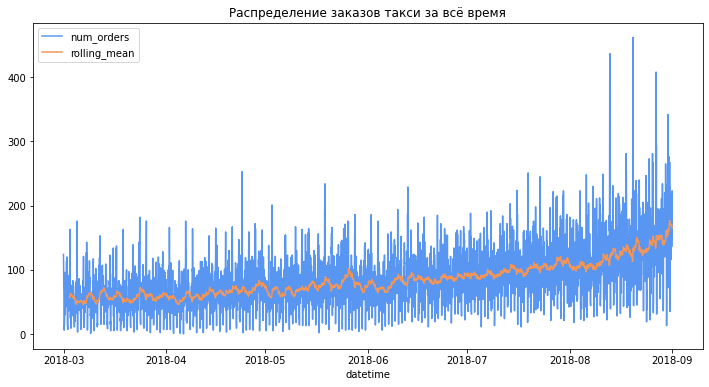

In [12]:
plt.figure(figsize = (12, 6))
fig = sns.lineplot(data = data_taxi[['num_orders', 'rolling_mean']], 
                   palette=["#5996F2", "#f29559"], 
                   dashes = False)
plt.title('Распределение заказов такси за всё время')
plt.show()

На графике выше видно, что среднее значение заказов такси постепенно увеличивается.

Посмотрим распределение заказов по дням недели: 

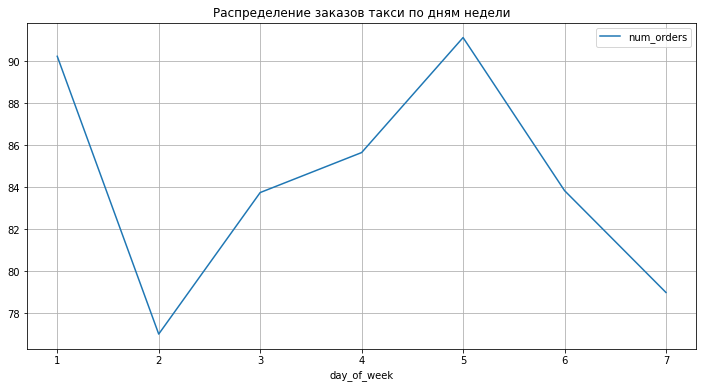

In [13]:
plt.figure(figsize = (12, 6))
fig = sns.lineplot(data = pd.pivot_table(data_taxi, 
                                         values = 'num_orders', 
                                         index = 'day_of_week', 
                                         aggfunc = 'mean'), 
                   color = '#5996F2')
plt.grid(True)
plt.title('Распределение заказов такси по дням недели')
plt.show()

Понедельник и пятница - пиковые дни для количества заказов.

Посмотрим распределение заказов по часам:

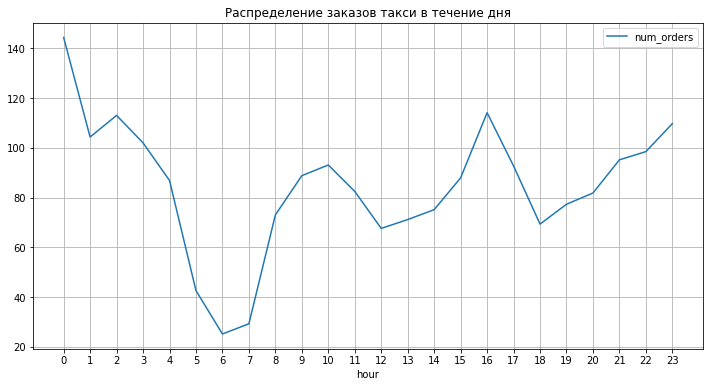

In [14]:
plt.figure(figsize = (12, 6))
fig = sns.lineplot(data = pd.pivot_table(data_taxi, 
                                         values = 'num_orders', 
                                         index = 'hour', 
                                         aggfunc = 'mean'), 
                   color = '#5996F2')
plt.grid(True)
plt.xticks(range(24))
plt.title('Распределение заказов такси в течение дня')
plt.show()

На графике видно ярко выраженные впадины и вершины, они могут быть обусловлены установившимся расписанием аэропорта:\
большинство вылетов в 00:00, 10:00, 16:00, что соответствует повышенному спросу на такси. \
Тогда как в 06:00 возможно пересменка сотрудников и далее снова с 08:00 такси становится восстребованным.   

### 2.2 Разберем временной ряд на три составляющие: тренд, сезонность и остаток

In [15]:
# для этого овспользуемся функцией seasonal_decompose()
decomposed = seasonal_decompose(data_taxi['num_orders'])

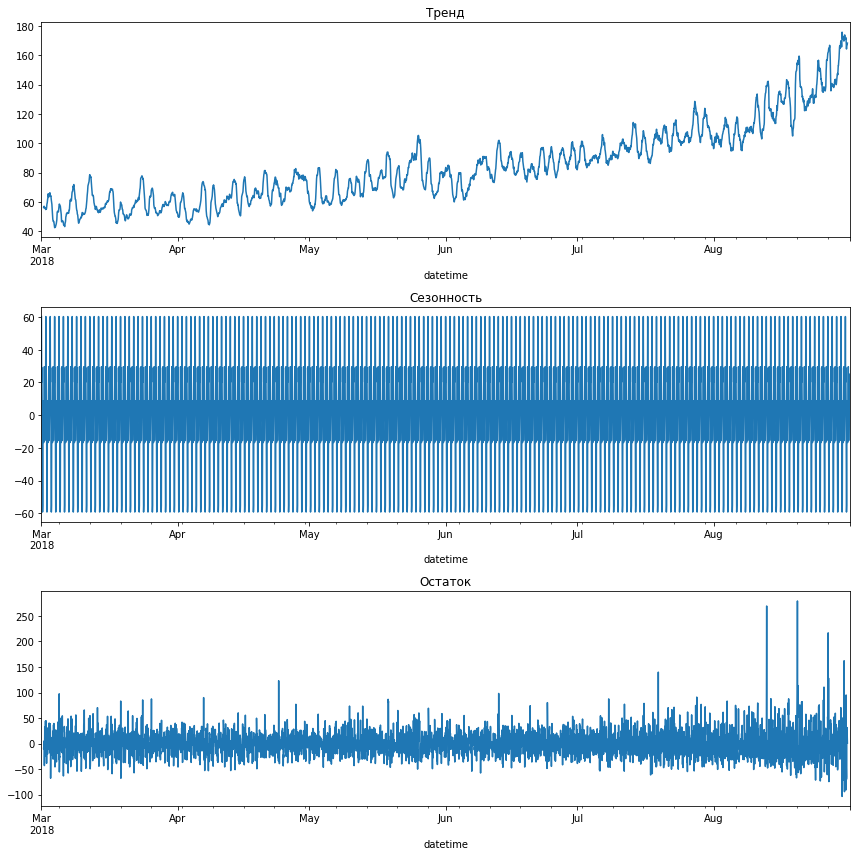

In [16]:
plt.figure(figsize = (12, 12))
plt.subplot(311)

decomposed.trend.plot(ax = plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca()) 
plt.title('Сезонность') # циклично повторяющиеся закономерности
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

Как я отмечал выше - существует тренд на увеличение общего количества заказов с марта по август;
- Временной ряд в **не является стационарным**, так как его среднее плавно растет.\
Остатки необъяснимы, а график сезонности в таком масштабе нечитаем, поэтому увеличим масштаб:

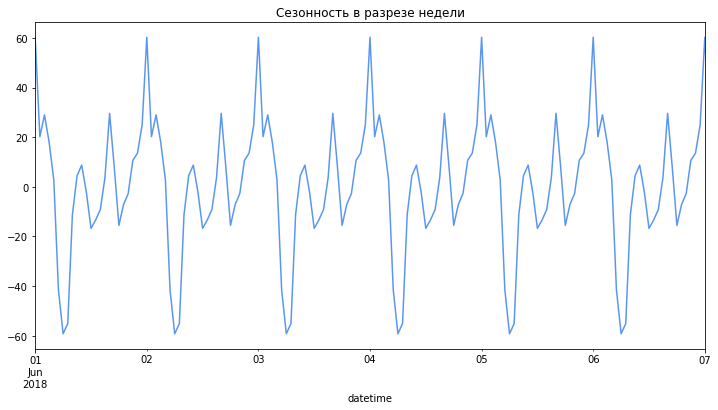

In [17]:
plt.figure(figsize = (12, 6))
decomposed.seasonal.plot(color = '#5996F2')
plt.title('Сезонность в разрезе недели')
plt.xlim(('2018-06-01', '2018-06-07'))
plt.show()

График отличается от графика распределения заказов по дням недели, появились отрицательные значения на оси ординат. Распределение сезонности напоминает распределение заказов в течение дня - провал утром и постепенное достижение максимума к 00:00. 

### 2.3 Найдём скользящее стандартное отклонение

Чтобы ряд сделать стационарным, найдём разности его значений

In [18]:
data_shift = data_taxi - data_taxi.shift()
data_shift = data_shift.drop(['rolling_mean', 'day_of_week', 'hour'], axis = 1)
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean() # размер окна зададим равный 24, т.к. в сутках 24 часа и данные у нас почасовые.
data_shift['std'] = data_shift['num_orders'].rolling(24).std()

<AxesSubplot:xlabel='datetime'>

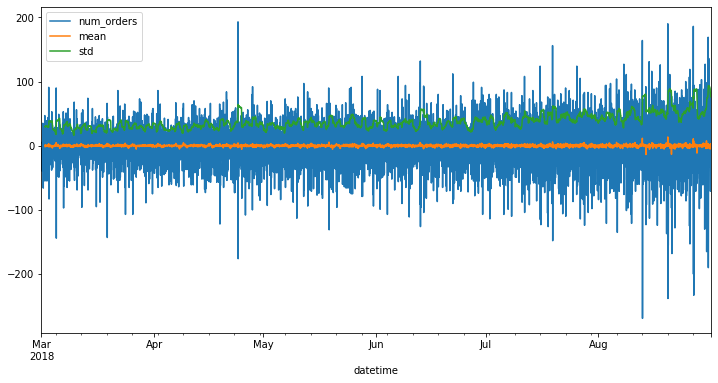

In [19]:
data_shift.plot(figsize = (12, 6)) 

### 2.4 Создание признаков: 

Напишем функцию make_features(), чтобы прибавить к таблице новые признаки (день недели и час мы уже добавили ранее).

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
        
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data 


In [21]:
# rolling_mean_size задаю равным 24, чтобы максимальый размер окна был 24, как в скользящем стандартном отклонении выше,
# max_lag - максимальный размер отставания так же задаем 24, т.к. данные почасовые. 
make_features(data_taxi, 24, 24)
data_taxi.head(5)

,num_orders,rolling_mean,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,4,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,4,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,4,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,4,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,4,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.5 Подготовка выборок

In [22]:
# используемые константы
RANDOM_STATE = 42
TEST_SIZE = 0.1 # установлено по условию задачи

In [23]:
train, test = train_test_split(data_taxi, 
                               shuffle = False, 
                               test_size = TEST_SIZE, 
                               random_state = RANDOM_STATE)

In [24]:
train = train.dropna()

In [25]:
X_train = train.drop('num_orders', axis = 1)
X_test = test.drop('num_orders', axis = 1)

In [26]:
y_train = train['num_orders']
y_test = test['num_orders']

In [27]:
print(f'Размер обучающей выборки:{(len(X_train)/len(data_taxi)):.0%}')
print("="*50)
print(f'Размер тестовой выборки:{(len(y_test)/len(data_taxi)):.0%}')

Размер обучающей выборки:89%
Размер тестовой выборки:10%


### ВЫВОД: 

В ходе анализа данных мы обнаружили:
- Виден общий тренд на увеличение заказов.
- Временной ряд в не является стационарным, так как его среднее плавно растет.
- В среднем больше всего заказов в понедельник и пятницу.
- В среднем меньше всего заказов во вторник и в воскресенье.
- В среднем пиковая нагрузка приходится на полночь.
- В среднем меньше всего заказов в шесть утра.

Написали функцию и создали новые признаки для моделирования;\
Подготовили выборки с соотношением 1:10. 

## Шаг 3. Обучение моделей

### 3.1 CatBoost

In [28]:
model = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=3)
params = {
    'n_estimators' : [40, 90],
    'random_state' : [RANDOM_STATE],
    'max_depth' : [2, 6, 9],
    'verbose':[10]
}

grid_cb = GridSearchCV(
    estimator = model, 
    param_grid = params, 
    cv = tscv, 
    n_jobs = -1, 
    scoring = 'neg_mean_squared_error'
)

In [29]:
%%time

grid_cb.fit(X_train, y_train)
cat_best_params = grid_cb.best_params_
print('Лучшие гиперпараметры: ', grid_cb.best_params_)
print(f'RMSE на тренировочной выборке: {round((-grid_cb.best_score_) ** 0.5, 3)}\n')

Learning rate set to 0.5
0:	learn: 25.1781901	total: 47.4ms	remaining: 1.85s
10:	learn: 18.3854345	total: 54.3ms	remaining: 143ms
20:	learn: 17.2051734	total: 60.5ms	remaining: 54.7ms
30:	learn: 16.4187607	total: 66.8ms	remaining: 19.4ms
39:	learn: 15.4769726	total: 72.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.4419574	total: 1.11ms	remaining: 43.5ms
10:	learn: 20.8914824	total: 9.98ms	remaining: 26.3ms
20:	learn: 19.7672272	total: 18.3ms	remaining: 16.6ms
30:	learn: 18.9371782	total: 27.1ms	remaining: 7.88ms
39:	learn: 18.3098970	total: 34.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 29.1452199	total: 1.51ms	remaining: 59.1ms
10:	learn: 22.4995809	total: 11.9ms	remaining: 31.5ms
20:	learn: 21.5904673	total: 22ms	remaining: 19.9ms
30:	learn: 20.5740369	total: 32.2ms	remaining: 9.36ms
39:	learn: 20.0675439	total: 41.5ms	remaining: 0us
Learning rate set to 0.289482
0:	learn: 26.6595519	total: 784us	remaining: 69.8ms
10:	learn: 19.1668471	total: 7.68ms	remaining: 55

### 3.2 LightGBM

In [30]:
model = LGBMRegressor()
params = {
    #'metric': ['l2'],
    'learning_rate':[x/10 for x in range(1, 6)],
    'boosting_type' : ['gbdt'],
    'n_estimators' : [200, 300],
    #'max_depth' : [12, 15, 16],     - убрал некоторые параметры, т.к. выходил длииииинный список с бесконечностями, но моделируется всё нормально. 
    'random_state' : [RANDOM_STATE],
    'force_col_wise': [True],
    #'num_leaves' : [128],
}
grid_lgbm = GridSearchCV(
    estimator = model,
    param_grid = params,
    cv = tscv, 
    n_jobs = -1, 
    scoring = 'neg_mean_squared_error'
)

In [31]:
%%time

grid_lgbm.fit(X_train, y_train)
gbm_best_params = grid_lgbm.best_params_
print('Лучшие гиперпараметры: ', grid_lgbm.best_params_)
print(f'RMSE на тренировочной выборке: {round((-grid_lgbm.best_score_) ** 0.5, 3)}\n')

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'learning_rate': 0.1, 'n_estimators': 200, 'random_state': 42}
RMSE на тренировочной выборке: 26.947

CPU times: user 15min 28s, sys: 5.46 s, total: 15min 33s
Wall time: 15min 43s


### 3.3 LinearRegression()

In [32]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('model', LinearRegression())
])

In [33]:
params = {
    'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],  # Варианты масштабирования
    'model__fit_intercept': [True, False],  
    'model__positive': [True, False],  
    'model__copy_X': [True, False]  
}

In [34]:
grid_lr = GridSearchCV(
    estimator = pipeline,
    param_grid = params,
    cv = tscv, 
    n_jobs = -1, 
    scoring = 'neg_mean_squared_error'
)

In [35]:
%%time

grid_lr.fit(X_train, y_train)
lr_best_params = grid_lr.best_estimator_
print('Лучшие гиперпараметры: ', grid_lr.best_params_)
print(f'RMSE на тренировочной выборке: {round((-grid_lr.best_score_) ** 0.5, 3)}\n')

Лучшие гиперпараметры:  {'model__copy_X': True, 'model__fit_intercept': False, 'model__positive': False, 'scaler': 'passthrough'}
RMSE на тренировочной выборке: 27.898

CPU times: user 5.34 s, sys: 5.77 s, total: 11.1 s
Wall time: 11.2 s


In [36]:
res = {
    'Model' : ['CatBoost()','LightGBM()', 'LinearRegression()'],
    'Тренировочное RMSE' :pd.Series([26.8, 26.947, 27.898]),
    'Тренировочное время, сек': pd.Series(['0 м. 13 сек.', '1 м. 17 сек.', '0 м. 9 сек.']),
    }

display(pd.DataFrame(res))

,Model,Тренировочное RMSE,"Тренировочное время, сек"
0,CatBoost(),26.800,0 м. 13 сек.
1,LightGBM(),26.947,1 м. 17 сек.
2,LinearRegression(),27.898,0 м. 9 сек.


### ВЫВОД: 
На данном этапе обучены три модели: 
- CatBoost(),
- LightGBM(),
- LinearRegression().
  
Все модели преодолели порог в 48 заказов - по этому критерию они все проходят, однако меньше всех ошибается **CatBoost()**, но если рассматривать вопрос скорости, который иногда может быть приоритетнее точности, то выигрывает **LinearRegression()**. Нужно искать компромисс между этими моделями.		


В разное время, в зависимости от загруженности jupiterHUB, моделирование занимает разное время, в прошлом проекте LGBM у меня занимал пол часа, в этом проекте облачные данные идентичны локальным. 

## Шаг 4. Проверка данных на тестовой выборке

Напомню, значение метрики RMSE на тестовой выборке должно быть не больше 48 заказов.

### 4.1 CatBoost()

In [37]:
%%time

cat_model = CatBoostRegressor(**cat_best_params)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
print(f'метрика RMSE на тестовой выборке = {round(mse(y_test, cat_pred)**0.5, 3)}')

Learning rate set to 0.360282
0:	learn: 34.4888873	total: 2.08ms	remaining: 185ms
10:	learn: 25.5466511	total: 19ms	remaining: 137ms
20:	learn: 24.6379653	total: 35.2ms	remaining: 116ms
30:	learn: 23.8773417	total: 47.5ms	remaining: 90.5ms
40:	learn: 23.1603082	total: 60ms	remaining: 71.7ms
50:	learn: 22.4888202	total: 72.2ms	remaining: 55.2ms
60:	learn: 22.0483414	total: 84.4ms	remaining: 40.1ms
70:	learn: 21.6404031	total: 96.2ms	remaining: 25.7ms
80:	learn: 21.3379432	total: 108ms	remaining: 12ms
89:	learn: 21.0881789	total: 119ms	remaining: 0us
метрика RMSE на тестовой выборке = 47.296
CPU times: user 133 ms, sys: 26.1 ms, total: 159 ms
Wall time: 836 ms


### 4.2 LightGBM()

In [38]:
# %%time

# model_gbm = LGBMRegressor(**gbm_best_params)
# model_gbm.fit(X_train, y_train)
# gbm_predict = model_gbm.predict(X_test)
# print(f'Test RMSE = {round(mse(y_test, gbm_predict)**0.5, 3)}')

### 4.3 LinearRegression()

In [39]:
# %%time

# lr_best_params.fit(X_train, y_train)
# lr_predict = lr_best_params.predict(X_test)
# print(f'Test RMSE = {round(mse(y_test, lr_predict)**0.5, 3)}')

In [40]:
res = {
    'Model' : ['CatBoost()'],
    'Тестовое RMSE' :pd.Series([47.296]),
    'Тестовое время, сек': pd.Series(['0 м. 2 сек.']),
    }

display(pd.DataFrame(res))

,Model,Тестовое RMSE,"Тестовое время, сек"
0,CatBoost(),47.296,0 м. 2 сек.


### Вывод: 
Тестовые данные показади, что меньше всех ошибается **LightGBM()**, но если рассматривать вопрос скорости, который иногда может быть приоритетнее точности, то **LinearRegression()** почти одинаково быстрая, как **CatBOOST**. 

# ВЫВОД по проекту: 

В данном исследовании перед нами стояла задача построить модель, которая умеет прогнозировать количество заказов такси на следующий час.
- Критерий, который важен заказчику:\
*Значение метрики RMSE на тестовой выборке должно быть не больше 48.*


1. На *первом* шаге мы **загрузили** и задали временной ряд через индекс, а так же произвели ресемплирование данных по одному часу.
В итоге в нашем распоряжении датафрейм data_taxi:
- **1** колонка и **4 416** строк.

2. В ходе **анализа** данных мы обнаружили:
- Виден общий тренд на увеличение заказов.
- Временной ряд в не является стационарным, так как его среднее плавно растет.
- В среднем больше всего заказов в понедельник и пятницу.
- В среднем меньше всего заказов во вторник и в воскресенье.
- В среднем пиковая нагрузка приходится на полночь.
- В среднем меньше всего заказов в шесть утра.

Написали функцию и создали новые признаки для моделирования;\
Подготовили выборки с соотношением 1:10. 

3. На данном этапе обучены три модели: 
- CatBoost(),
- LightGBM(),
- LinearRegression().
  
Все модели преодолели порог ошибки в 48 заказов - по этому критерию они все проходят, однако меньше всех ошибается **LightGBM()**, но если рассматривать вопрос скорости, который иногда может быть приоритетнее точности, то выигрывает **LinearRegression()**.

Нужно искать компромисс между этими моделями, но я бы выбрал **линейную регрессию**.

4. На этапе проверки данных на тестовой выборке:

Качество моделей на тестовой выборке:

| Модель     | Тестовое RMSE | Время обучения |
|:-----------|--------------:|:--------------:|
| CatBoost   |        47.296 |  0 мин 02 сек  |
 